In [31]:
# imports
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy.ndimage import gaussian_filter1d
# %matplotlib inline

In [2]:
# import configurations
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
# read files
sentiment_df = pd.read_pickle("../data/cleaned/tweets_verified_sentiment_2020-2021.pkl")
tweet_df = pd.read_pickle("../data/cleaned/tweets_verified_2020-2021_cleaned.pkl")
bitcoin_df = pd.read_csv("../data/raw/bitcoin_value_2020-2021.csv", parse_dates=["datetime"])
bitcoin_df['diff'] = bitcoin_df['close_bitcoin'].diff()

In [4]:
tweet_sentiment_df = pd.merge(tweet_df, sentiment_df, on='id')
df_by_date = tweet_sentiment_df.groupby(tweet_sentiment_df['created_at'].dt.date).agg({
    'replies_count':'sum',
    'retweets_count':'sum',
    'likes_count':'sum',
    'sentiment': 'sum'
}).reset_index()

df_by_date = df_by_date.astype({'created_at':'datetime64[ns]'})

df_by_date.head()

,created_at,replies_count,retweets_count,likes_count,sentiment
0,2020-01-01,963,1854,10851,20.1830
1,2020-01-02,748,2839,7820,17.6956
2,2020-01-03,1683,3142,11075,24.9690
3,2020-01-04,745,1366,9155,10.2591
4,2020-01-05,3326,2493,10028,8.8219


In [5]:
df = pd.merge(df_by_date, bitcoin_df[['datetime', 'diff']], left_on='created_at', right_on='datetime').dropna()
df.head()

,created_at,replies_count,retweets_count,likes_count,sentiment,datetime,diff
1,2020-01-02,748,2839,7820,17.6956,2020-01-02,379.25
2,2020-01-03,1683,3142,11075,24.9690,2020-01-03,9.15
3,2020-01-04,745,1366,9155,10.2591,2020-01-04,4.64
4,2020-01-05,3326,2493,10028,8.8219,2020-01-05,399.25
5,2020-01-06,3914,3898,7916,6.4118,2020-01-06,387.28


In [40]:
# model training
features = ['replies_count', 'retweets_count', 'likes_count']
output = 'diff'

# split test/train
X_train, X_test, y_train, y_test = train_test_split(
    df[features], 
    df[output], 
    test_size = 0.3,
    random_state = 42
)

## setup pipeline
ridge = Ridge()
steps = [('scaler', StandardScaler()),
        ('ridge', ridge)]
pipeline = Pipeline(steps)
parameters = {'ridge__alpha':np.logspace(-2, 20, 200)}

grid = GridSearchCV(pipeline, parameters)

## fit data
grid.fit(X_train, y_train)

## Compute metrics
r2 = grid.score(X_test, y_test)
print("Tuned Ridge Alpha: {}".format(grid.best_params_))
print("Tuned Ridge R squared: {}".format(r2))

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-02, 1.28989026e-02, 1.66381689e-02, 2.14614120e-02,
       2.76828663e-02, 3.57078596e-02, 4.60592204e-02, 5.94113398e-02,
       7.66341087e-02, 9.88495905e-02, 1.27505124e-01, 1.64467618e-01,
       2.12145178e-01, 2.73644000e-01, 3.52970730e-01, 4.55...
       2.86606762e+17, 3.69691271e+17, 4.76861170e+17, 6.15098579e+17,
       7.93409667e+17, 1.02341140e+18, 1.32008840e+18, 1.70276917e+18,
       2.19638537e+18, 2.83309610e+18, 3.65438307e+18, 4.71375313e+18,
       6.08022426e+18, 7.84282206e+18, 1.01163798e+19, 1.30490198e+19,
       1.68318035e+19, 2.17111795e+19, 2.80050389e+19, 3.61234270e+19,
       4.65952567e+19, 6.01027678e+19, 7.75259749e+19, 1.00000000e+20])})

Tuned Ridge Alpha: {'ridge__alpha': 34.489622604057594}
Tuned Ridge R squared: -0.01056433569891202


In [39]:
ridge.alpha = 34.1234
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
print("MAE: ", mean_squared_error(y_pred, y_test))
print("MSE: ", mean_absolute_error(y_pred, y_test))

Ridge(alpha=36.1234)

MAE:  1805153.7360548396
MSE:  854.1067357123294


(18628.0, 18673.0)

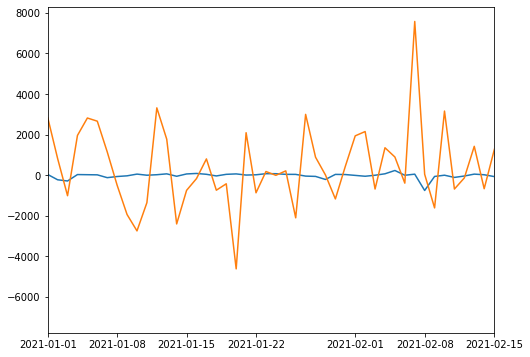

In [38]:
df['output'] = ridge.predict(df[features])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['datetime'], df['output'])
ax.plot(df['datetime'], df['diff'])

ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-02-15'))

plt.show()

In [4]:
sent_obj = SentimentIntensityAnalyzer()
sent_data = df['tweet']

pest_words = {
    'up': 2.0,
    'down': -2.0,
    'green' : 2.0,
    'red' : -2.0,
    'bull' : 2.0,
    'bear' : -2.0,
    'buy' : 2.0,
    'bought' : 2.0,
    'sell' : -2.0,
    'sold' : -2.0,
    'moon': 2
}

new_si = SentimentIntensityAnalyzer()
new_si.lexicon.update(pest_words)

sentiment_update = []
for i in tqdm(sent_data):
    sentiment_update.append(sent_obj.polarity_scores(i))

  0%|          | 0/312204 [00:00<?, ?it/s]

In [10]:
df = pd.merge(df_bitcoin, df_tweet, on="id")
df.head()

,created_at,id,conversation_id,user_id,username,name,tweet,language,mentions,urls,...,retweets_count,likes_count,hashtags,cashtags,link,quote_url,video,thumbnail,reply_to,sentiment
0,2020-01-01 00:08:28-05:00,1212239143687741440,1212239143687741440,20646945,dumbfoundead,dumbfoundead.eth,bitcoin worst decision made decade,en,[],[],...,15,409,[],[],https://twitter.com/dumbfoundead/status/121223...,<NA>,False,<NA>,[],-0.6249
1,2020-01-01 00:54:35-05:00,1212250748815208448,1212250748815208448,636023721,neuroecology,Adam J Calhoun,ask someone went back ten years use informatio...,en,[],[],...,0,4,[],[],https://twitter.com/neuroecology/status/121225...,<NA>,False,<NA>,[],0.3612
2,2020-01-01 02:00:25-05:00,1212267316789952512,1212267316789952512,631810714,cnbctv18news,CNBC-TV18,bitcoin rally begun 2013 reached peak 20 00 20...,en,[],['https://www.cnbctv18.com/market/currency/bit...,...,0,4,['bitcoin'],[],https://twitter.com/CNBCTV18News/status/121226...,<NA>,False,<NA>,[],0.1027
3,2020-01-01 02:18:48-05:00,1212271940502638593,1212271940502638593,14654494,excellion,Samson Mow,wishing bitcoin ultra enthusiasts happy new ye...,en,"[{'screen_name': 'blockstream', 'name': 'block...",[],...,17,158,"['bitcoin', 'liquidnetwork']",[],https://twitter.com/Excellion/status/121227194...,<NA>,True,https://pbs.twimg.com/media/ENLa5toU0AAvhC1.jpg,[],0.9136
4,2020-01-01 02:39:29-05:00,1212277146401402880,1212277146401402880,1066972567943053312,hindustantimes,Hindustan Times,breaking bitcoin 9 00 00 rise last decade left...,en,[],['http://www.hindustantimes.com/tech/breaking-...,...,0,0,[],[],https://twitter.com/HindustanTimes/status/1212...,<NA>,False,<NA>,[],-0.5106


In [5]:
sentiment_update[:4]
len(sentiment_update)

[{'neg': 0.506, 'neu': 0.494, 'pos': 0.0, 'compound': -0.6249},
 {'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'compound': 0.3612},
 {'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'compound': 0.1027},
 {'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'compound': 0.9136}]

312204

In [6]:
all_compound = [one_tok['compound'] for one_tok in sentiment_update]
df['compound'] = pd.DataFrame(all_compound)
df[['tweet', 'compound']]

,tweet,compound
0,bitcoin worst decision made decade,-0.6249
1,ask someone went back ten years use informatio...,0.3612
2,bitcoin rally begun 2013 reached peak 20 00 20...,0.1027
3,wishing bitcoin ultra enthusiasts happy new ye...,0.9136
4,breaking bitcoin 9 00 00 rise last decade left...,-0.5106
...,...,...
312199,bitcoin__art fair enough,0.3182
312200,happy new year bitcoin https hduqndkuua,0.5719
312201,rubiconcapital_ buy bitcoin amp chill defund p...,0.0000
312202,bitcoin faces uncertain 2022 record year https...,-0.2960


In [14]:
df

,created_at,id,conversation_id,user_id,username,name,tweet,language,mentions,urls,...,likes_count,hashtags,cashtags,link,quote_url,video,thumbnail,reply_to,compound,compound_weight
0,2020-01-01 00:08:28-05:00,1212239143687741440,1212239143687741440,20646945,dumbfoundead,dumbfoundead.eth,bitcoin worst decision made decade,en,[],[],...,409,[],[],https://twitter.com/dumbfoundead/status/121223...,<NA>,False,<NA>,[],-0.6249,-2.4996
1,2020-01-01 00:54:35-05:00,1212250748815208448,1212250748815208448,636023721,neuroecology,Adam J Calhoun,ask someone went back ten years use informatio...,en,[],[],...,4,[],[],https://twitter.com/neuroecology/status/121225...,<NA>,False,<NA>,[],0.3612,0.3612
2,2020-01-01 02:00:25-05:00,1212267316789952512,1212267316789952512,631810714,cnbctv18news,CNBC-TV18,bitcoin rally begun 2013 reached peak 20 00 20...,en,[],['https://www.cnbctv18.com/market/currency/bit...,...,4,['bitcoin'],[],https://twitter.com/CNBCTV18News/status/121226...,<NA>,False,<NA>,[],0.1027,0.1027
3,2020-01-01 02:18:48-05:00,1212271940502638593,1212271940502638593,14654494,excellion,Samson Mow,wishing bitcoin ultra enthusiasts happy new ye...,en,"[{'screen_name': 'blockstream', 'name': 'block...",[],...,158,"['bitcoin', 'liquidnetwork']",[],https://twitter.com/Excellion/status/121227194...,<NA>,True,https://pbs.twimg.com/media/ENLa5toU0AAvhC1.jpg,[],0.9136,1.8272
4,2020-01-01 02:39:29-05:00,1212277146401402880,1212277146401402880,1066972567943053312,hindustantimes,Hindustan Times,breaking bitcoin 9 00 00 rise last decade left...,en,[],['http://www.hindustantimes.com/tech/breaking-...,...,0,[],[],https://twitter.com/HindustanTimes/status/1212...,<NA>,False,<NA>,[],-0.5106,-0.5106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312199,2021-12-31 23:20:12-05:00,1477132523826147330,1477131257301520385,151805556,adeldmeyer,Adel,bitcoin__art fair enough,en,[],[],...,1,[],[],https://twitter.com/AdeldMeyer/status/14771325...,<NA>,False,<NA>,"[{'screen_name': 'Bitcoin__art', 'name': 'bitc...",0.3182,0.3182
312200,2021-12-31 23:28:45-05:00,1477134677148323841,1477134677148323841,1414971,jaygould,Jay Gould,happy new year bitcoin https hduqndkuua,en,[],[],...,12,['bitcoin'],[],https://twitter.com/jaygould/status/1477134677...,<NA>,True,https://pbs.twimg.com/media/FH_WKPYXsAQRYg_.jpg,[],0.5719,0.5719
312201,2021-12-31 23:38:06-05:00,1477137028894670855,1477132718341337095,10446482,nvk,DETERMINISTIC OPTIMISM,rubiconcapital_ buy bitcoin amp chill defund p...,en,[],[],...,8,[],[],https://twitter.com/nvk/status/147713702889467...,<NA>,False,<NA>,"[{'screen_name': 'rubiconcapital_', 'name': 'K...",0.0000,0.0000
312202,2021-12-31 23:43:13-05:00,1477138318982725633,1477138318982725633,22594051,staronline,The Star,bitcoin faces uncertain 2022 record year https...,en,[],['https://www.thestar.com.my/tech/tech-news/20...,...,7,[],[],https://twitter.com/staronline/status/14771383...,<NA>,False,<NA>,[],-0.2960,-0.2960


In [7]:
# weight retweet
df['compound'] = df['compound'].astype(float)
compound_weight = []
def get_weight_score(row):
    famous_score = row['replies_count']*1/3 + row['retweets_count']*1/3 + row['likes_count']*1/3
    if (famous_score < 50):
        compound_weight.append(row['compound'])
    elif (famous_score > 50) and (famous_score < 200):
        compound_weight.append(row['compound']*2)
    elif (famous_score > 200) and (famous_score < 500):
        compound_weight.append(row['compound']*4)
    elif (famous_score > 500) and (famous_score < 999):
        compound_weight.append(row['compound']*8)
    elif (famous_score > 1000) and (famous_score < 3000):
        compound_weight.append(row['compound']*16)
    elif (famous_score > 3000) and (famous_score < 9999):
        compound_weight.append(row['compound']*32)
    else:
        compound_weight.append(row['compound']*64)

df.progress_apply(get_weight_score, axis=1)
df['compound_weight'] = compound_weight
df['compound_weight'] 

  0%|          | 0/312204 [00:00<?, ?it/s]

0         None
1         None
2         None
3         None
4         None
          ... 
312199    None
312200    None
312201    None
312202    None
312203    None
Length: 312204, dtype: object

0        -2.4996
1         0.3612
2         0.1027
3         1.8272
4        -0.5106
           ...  
312199    0.3182
312200    0.5719
312201    0.0000
312202   -0.2960
312203    0.6249
Name: compound_weight, Length: 312204, dtype: float64

In [8]:
# create date-time column
df_bydate = df.groupby(df['created_at'].dt.date).agg({"compound_weight" : "mean"}).reset_index()
df_bydate

,created_at,compound_weight
0,2020-01-01,0.352124
1,2020-01-02,0.087454
2,2020-01-03,0.369486
3,2020-01-04,0.158883
4,2020-01-05,0.192724
...,...,...
726,2021-12-27,0.414114
727,2021-12-28,0.923539
728,2021-12-29,0.261120
729,2021-12-30,0.504782


In [9]:
# import bitcoin values
bitcoin_value_df = pd.read_csv("../data/raw/bitcoin_value_2020-2021.csv", parse_dates=["datetime"])
bitcoin_value_df['diff'] = bitcoin_value_df['close_bitcoin'].diff()
bitcoin_value_df.head()

,Unnamed: 0,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,datetime,diff
0,0,31951.483932,7200.77,7212.50,6924.74,6965.71,127.19,13.0105,0.03269,295567.0,475461.0,3.156424,1.813511e+07,2.860097e+07,9.671772e+07,2020-01-01,NaN
1,1,68428.500451,6965.49,7405.00,6871.04,7344.96,134.35,13.6474,0.03417,316517.0,523231.0,2.839931,1.813689e+07,6.828297e+07,1.159241e+08,2020-01-02,379.25
2,2,29987.974977,7345.00,7404.00,7272.21,7354.11,134.20,13.8092,0.03434,287215.0,465366.0,3.339583,1.813869e+07,1.368703e+08,1.152381e+08,2020-01-03,9.15
3,3,38331.085604,7354.19,7495.00,7318.00,7358.75,135.37,14.0532,0.03460,287779.0,459065.0,3.481424,1.814046e+07,5.018183e+07,1.118084e+08,2020-01-04,4.64
4,4,54635.695316,7357.64,7795.34,7346.76,7758.00,144.15,14.9471,0.03732,299146.0,522665.0,3.192535,1.814225e+07,4.817756e+07,9.260207e+07,2020-01-05,399.25


(18628.0, 18992.0)

Text(0.5, 0, 'Time (day)')

Text(0, 0.5, 'Compound Weight')

Text(0, 0.5, 'Differential Bitcoin Value (delta dollar)')

(-1800.0, 2600.0)

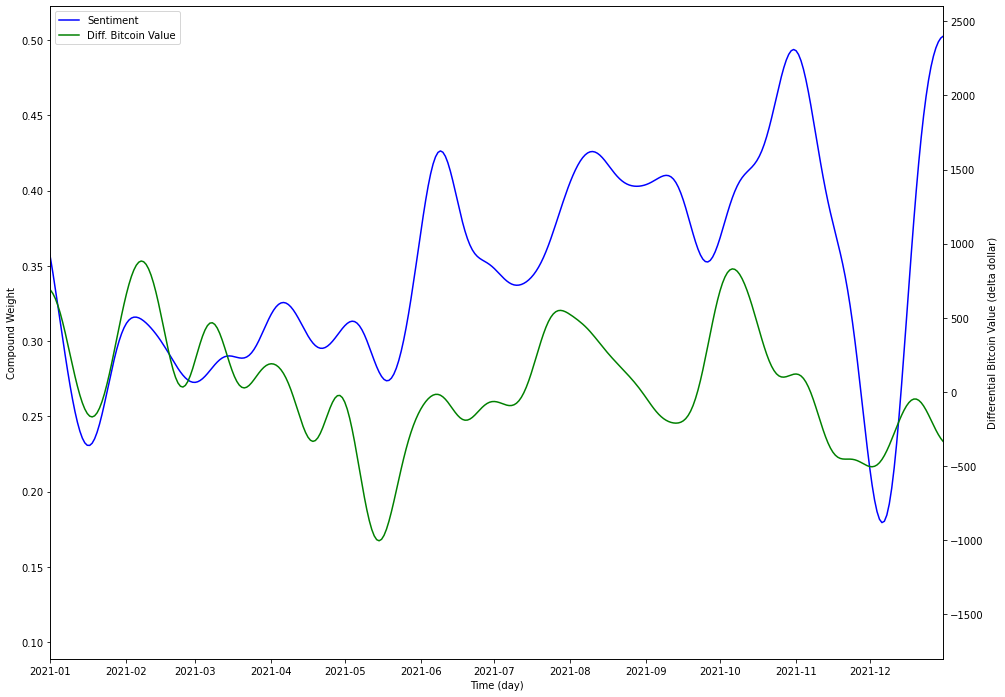

In [10]:
# graph results
fig, ax1 = plt.subplots(figsize=(16, 12))

lns1 = ax1.plot(df_bydate['created_at'], gaussian_filter1d(df_bydate['compound_weight'], 7), label="Sentiment", color="blue")
ax1.set_xlim([pd.Timestamp("2021-01-01"), pd.Timestamp("2021-12-31")])
ax1.set_xlabel("Time (day)")
ax1.set_ylabel("Compound Weight")

ax2 = ax1.twinx()
lns2 = ax2.plot(bitcoin_value_df["datetime"], gaussian_filter1d(bitcoin_value_df["diff"], 7), label="Diff. Bitcoin Value", color="green")
ax2.set_ylabel("Differential Bitcoin Value (delta dollar)")
ax2.set_ylim([-1800, 2600])

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

,replies_count,retweets_count,likes_count
created_at,,,
2020-01-01,7.766129,14.951613,87.508065
2020-01-02,5.582090,21.186567,58.358209
2020-01-03,11.371622,21.229730,74.831081
2020-01-04,8.662791,15.883721,106.453488
2020-01-05,30.236364,22.663636,91.163636
